In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
from scipy.cluster import hierarchy as sch
from matplotlib import pyplot as plt
from copy import deepcopy
%matplotlib inline

In [5]:
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [6]:
import csv
import pandas as pd

In [8]:
vizgen_dir = Path().resolve() /'home'/'jupyter'/'region_6'
adata = sq.read.vizgen(
    path='/home/jupyter/region_6',
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    #transformation_file="micron_to_mosaic_pixel_transform.csv",
)

In [9]:
ser_exp = adata.to_df().sum(axis=1)
adata.obs['ExpressionCounts'] = ser_exp

<AxesSubplot:xlabel='ExpressionCounts', ylabel='Count'>

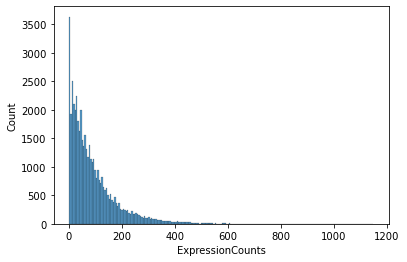

In [10]:
#fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(
    adata.obs["ExpressionCounts"],
    #log_scale=10,
    #kde=False,
    #ax=axs[0],
)
#g.set(xlim=(0, 500))

[(0.0, 1000.0)]

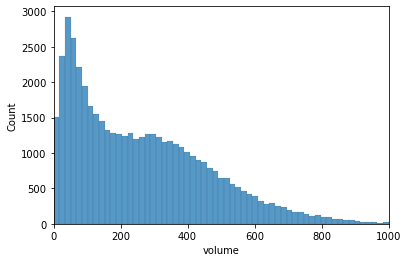

In [8]:
g=sns.histplot(
    adata.obs["volume"],
    #kde=False,
    #bins=60,
    #ax=axs[2],
)
g.set(xlim=(0, 1000))

In [6]:
adata

AnnData object with n_obs × n_vars = 47582 × 228
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y', 'ExpressionCounts'
    uns: 'spatial'
    obsm: 'spatial'

In [12]:
sc.pp.filter_cells(adata, min_counts=10)
#sc.pp.filter_genes(adata, min_cells=10)

In [14]:
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

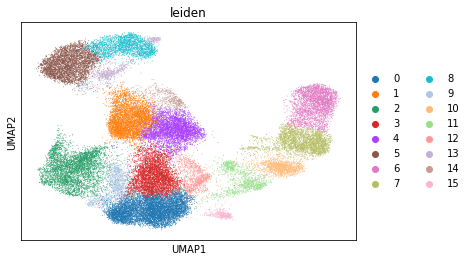

In [15]:
sc.pl.umap(
    adata,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

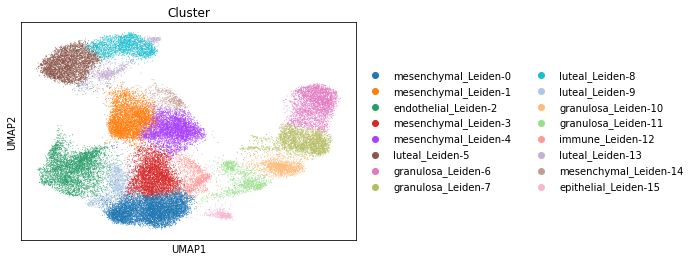

In [23]:
sc.pl.umap(
    adata,
    color=[
        "Cluster",
    ],
    wspace=0.4,
    #figsize=(15, 15),
    cmap = 'tab20b',
)

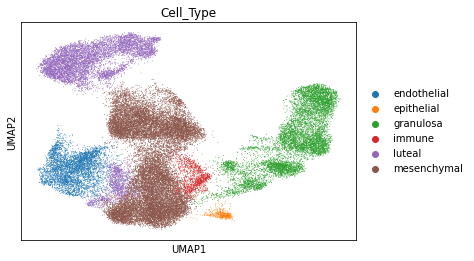

In [24]:
sc.pl.umap(
    adata,
    color=[
        "Cell_Type",
    ],
    wspace=0.4,
    #figsize=(15, 15),
    cmap = 'tab20b',
)

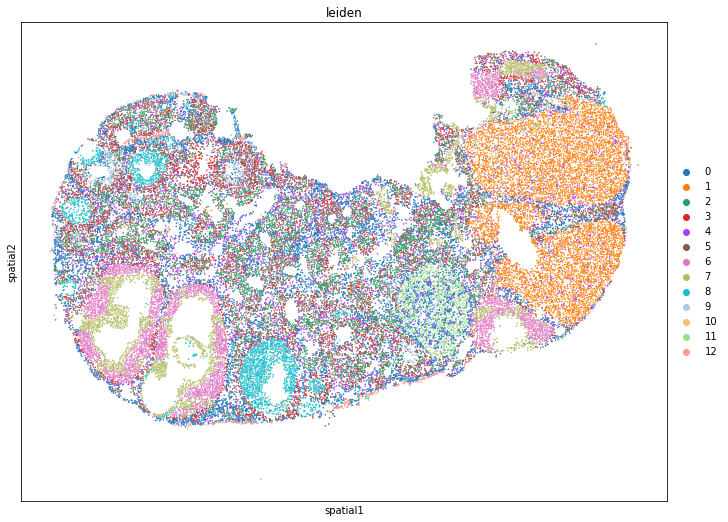

In [38]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="leiden",
    size=0.5,
    library_id='spatial',
    figsize=(10, 10)
)

In [18]:
ser_counts = adata.obs['leiden'].value_counts()
ser_counts.name = 'cell counts'
meta_leiden = pd.DataFrame(ser_counts)

cat_name = 'leiden'
sig_leiden = pd.DataFrame(columns=adata.var_names, index=adata.obs[cat_name].cat.categories)
for clust in adata.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = adata[adata.obs[cat_name].isin([clust]),:].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ['Leiden-' + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden['leiden'] = pd.Series(meta_leiden.index.tolist(), index=meta_leiden.index.tolist())

In [19]:
meta_leiden

cell counts     leiden
Leiden-0          6801   Leiden-0
Leiden-1          4524   Leiden-1
Leiden-2          4228   Leiden-2
Leiden-3          4180   Leiden-3
Leiden-4          4144   Leiden-4
Leiden-5          3688   Leiden-5
Leiden-6          2972   Leiden-6
Leiden-7          2728   Leiden-7
Leiden-8          2070   Leiden-8
Leiden-9          1478   Leiden-9
Leiden-10         1436  Leiden-10
Leiden-11         1273  Leiden-11
Leiden-12         1223  Leiden-12
Leiden-13          761  Leiden-13
Leiden-14          483  Leiden-14
Leiden-15          418  Leiden-15

In [20]:
meta_gene = pd.DataFrame(index=sig_leiden.index.tolist())
meta_gene['info'] = pd.Series('', index=meta_gene.index.tolist())
meta_gene['Markers'] = pd.Series('N.A.', index=sig_leiden.index.tolist())
meta_gene.loc[common_marker_genes, 'Markers'] = df_ref_panel.loc[common_marker_genes, 'NOTES']

meta_leiden['Cell_Type'] = pd.Series('N.A.', index=meta_leiden.index.tolist())
num_top_genes = 10
for inst_cluster in sig_leiden.columns.tolist():
  top_genes = sig_leiden[inst_cluster].sort_values(ascending=False).index.tolist()[:num_top_genes]

  inst_ser = meta_gene.loc[top_genes, 'Markers']
  inst_ser = inst_ser[inst_ser != 'N.A.']
  ser_counts = inst_ser.value_counts()

  max_count = ser_counts.max()

  max_cat = '_'.join(sorted(ser_counts[ser_counts == max_count].index.tolist()))
  max_cat = max_cat.replace(' marker', '').replace(' ', '-')

  print(inst_cluster, max_cat)
  meta_leiden.loc[inst_cluster, 'Cell_Type'] = max_cat

Leiden-0 mesenchymal-
Leiden-1 mesenchymal-
Leiden-2 endothelial_endothelial-_epithelial-_luteal-_mesenchymal-
Leiden-3 mesenchymal-
Leiden-4 mesenchymal-
Leiden-5 luteal_mesenchymal-
Leiden-6 mesenchymal-
Leiden-7 GC_Small
Leiden-8 mesenchymal-
Leiden-9 mesenchymal-
Leiden-10 GC_Small
Leiden-11 GC_Small_luteal-_mesenchymal-
Leiden-12 mesenchymal-
Leiden-13 luteal
Leiden-14 mesenchymal-
Leiden-15 epithelial-


In [21]:
n = 0

for inst_cluster in sig_leiden.columns.tolist():
    top_genes = sig_leiden[inst_cluster].sort_values(ascending=False).index.tolist()[:num_top_genes]
    print(top_genes)

['Col1a2', 'Dcn', 'Col1a1', 'Col3a1', 'Mfap4', 'Hmgcs2', 'Dhrs3', 'Idh1', 'C1s1', 'Cdh11']
['Aldh1a1', 'Idh1', 'Cyp11a1', 'Hmgcs2', 'Mgarp', 'Inha', 'Fdx1', 'Star', 'Hao2', 'Prlr']
['Ly6e', 'Pecam1', 'Cldn5', 'Idh1', 'Vim', 'Egfl7', 'Cyp11a1', 'Aldh1a1', 'Dhrs3', 'Star']
['Dcn', 'Aldh1a1', 'Col3a1', 'Col1a2', 'Idh1', 'Hmgcs2', 'Cyp11a1', 'Col1a1', 'Dhrs3', 'Fdx1']
['Cyp17a1', 'Aldh1a1', 'Cyp11a1', 'Idh1', 'Hmgcs2', 'Fdx1', 'Inha', 'Mgarp', 'Star', 'Prlr']
['Idh1', 'Star', 'Gm2a', 'Cyp11a1', 'Fdx1', 'Prlr', 'Sfrp4', 'Runx2', 'Hao2', 'Mgarp']
['Nap1l5', 'Idh1', 'Rasd1', 'Serpine2', 'Mgarp', 'Fshr', 'Coasy', 'Aldh1a1', 'Inhba', 'Ptges']
['Inha', 'Inhba', 'Serpine2', 'Nap1l5', 'Mro', 'Fst', 'Idh1', 'Myo6', 'Fshr', 'Rasd1']
['Gm2a', 'Sfrp4', 'Idh1', 'Fdx1', 'Hao2', 'Mgarp', 'Runx2', 'Hmgcs2', 'Rgcc', 'Star']
['Col1a2', 'Idh1', 'Col3a1', 'Star', 'Col1a1', 'Cyp11a1', 'Dcn', 'Vim', 'C1s1', 'Gm2a']
['Inha', 'Serpine2', 'Fst', 'Hmgcs2', 'Fshr', 'Mro', 'Nap1l5', 'Myo6', 'Idh1', 'Dhrs3']
['Inha', 

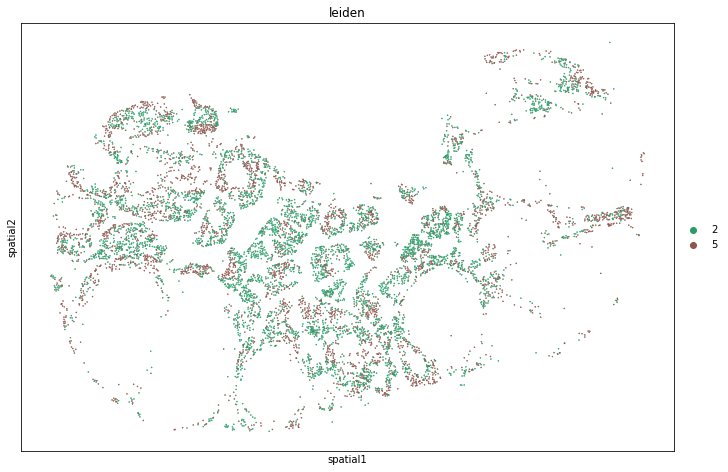

In [63]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="leiden",
    groups = ['2','5'],
    size=0.5,
    library_id='spatial',
    figsize=(10, 10),
    cmap = 'tab20b',
)

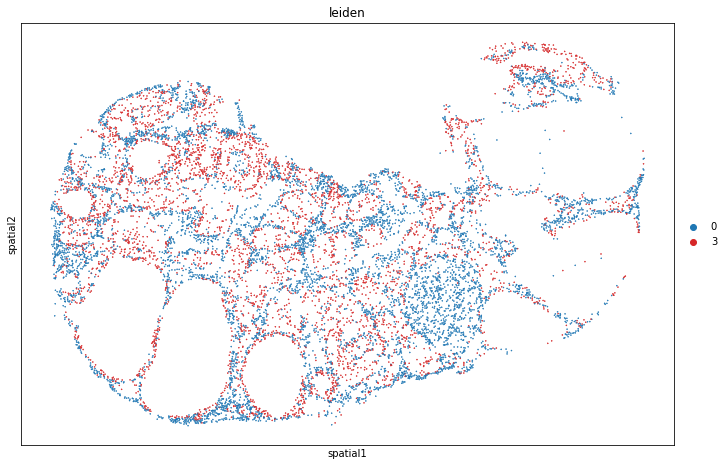

In [62]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="leiden",
    groups = ['0','3'],
    size=0.5,
    library_id='spatial',
    figsize=(10, 10),
    cmap = 'tab20b',
)

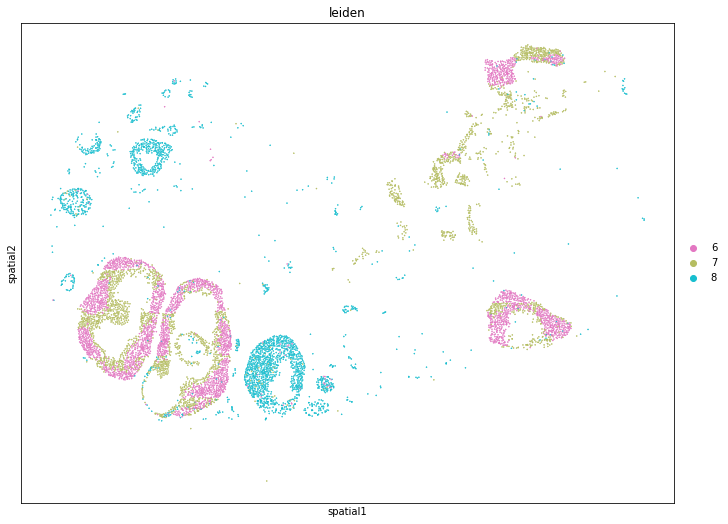

In [48]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="leiden",
    groups = ['6','7','8'],
    size=0.5,
    library_id='spatial',
    figsize=(10, 10),
    cmap = 'tab20b',
)

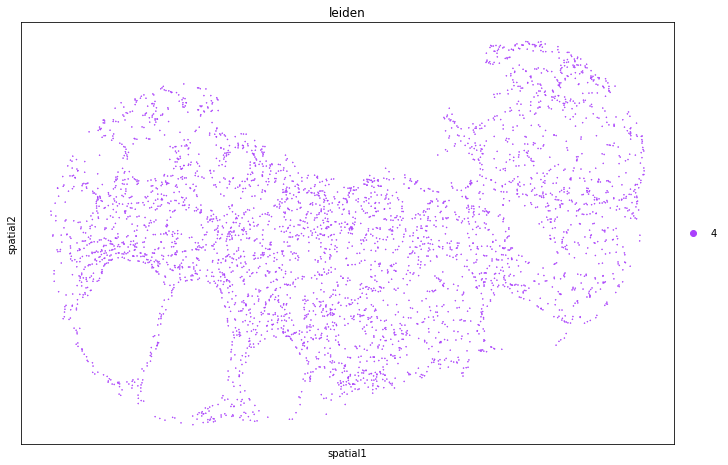

In [51]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="leiden",
    groups = ['4'],
    size=0.5,
    library_id='spatial',
    figsize=(10, 10),
    cmap = 'tab20b',
)

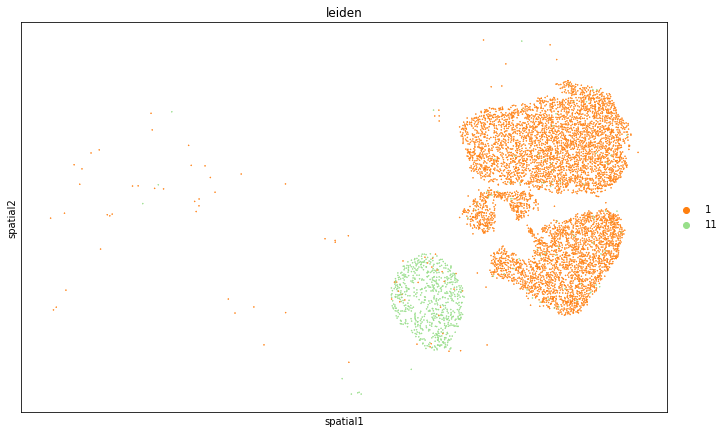

In [60]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="leiden",
    groups = ['1','11'],
    size=0.5,
    library_id='spatial',
    figsize=(10, 10),
    cmap = 'tab20b',
)

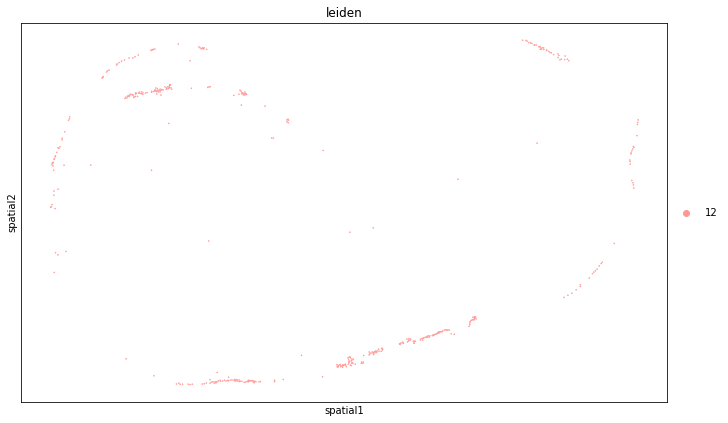

In [53]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="leiden",
    groups = ['12'],
    size=0.5,
    library_id='spatial',
    figsize=(10, 10),
    cmap = 'tab20b',
)

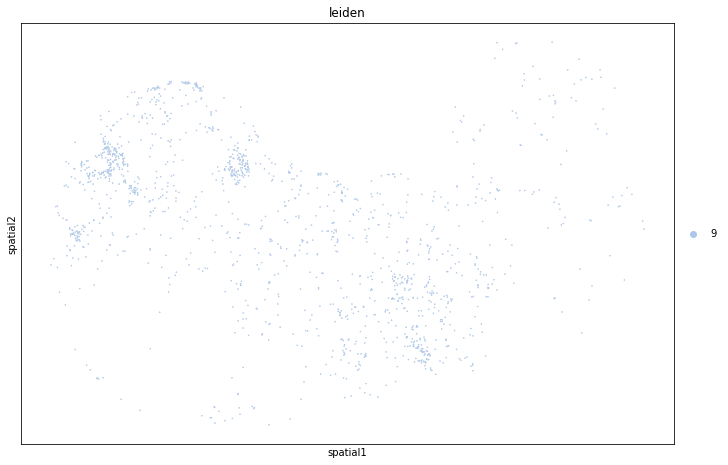

In [57]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="leiden",
    groups = ['9'],
    size=0.5,
    library_id='spatial',
    figsize=(10, 10),
    cmap = 'tab20b',
)

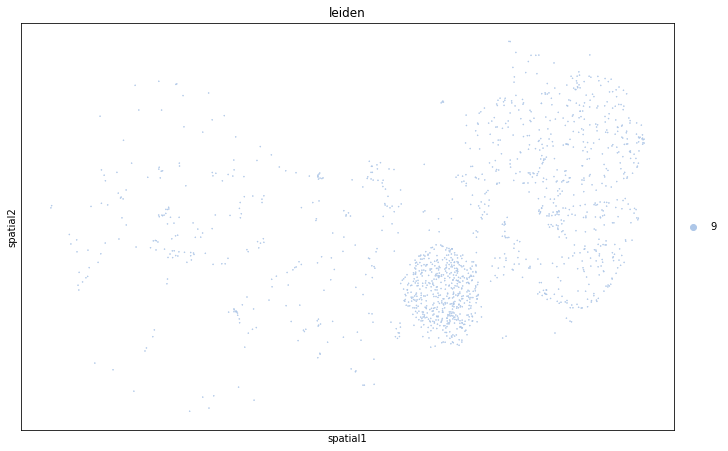

In [23]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="leiden",
    groups = ['9'],
    size=0.5,
    library_id='spatial',
    figsize=(10, 10),
    cmap = 'tab20b',
)

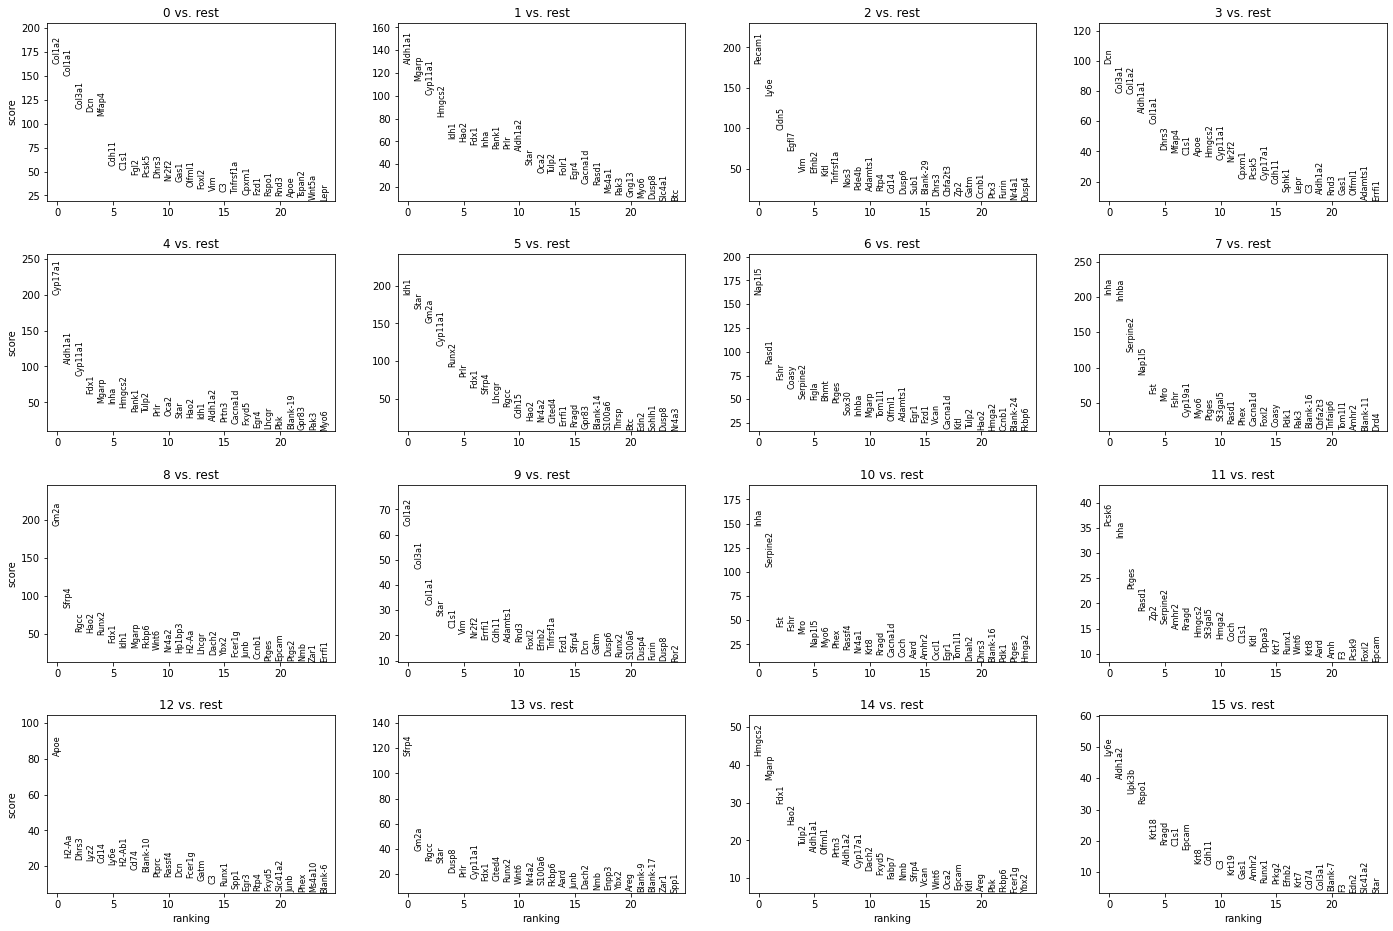

In [22]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")

In [15]:
def get_new_value(leiden_value):
    if leiden_value in ['Leiden-0','Leiden-3']:
        return 'stroma'
    elif leiden_value in ['Leiden-1','Leiden-4','Leiden-14']:
        return 'theca'
    elif leiden_value in ['Leiden-5','Leiden-13','Leiden-8','Leiden-9']:
        return 'luteal'
    elif leiden_value in ['Leiden-15']:
        return 'epithelial'
    elif leiden_value in ['Leiden-6', 'Leiden-7','Leiden-11','Leiden-10']:
        return 'granulosa'
    elif leiden_value in ['Leiden-12']:
        return 'immune'
    elif leiden_value in ['Leiden-2']:
        return 'endothelial'
    else:
        return 'unknown1'

# apply the function to each row of the 'Leiden' column using the apply() method
meta_leiden['Cell_Type'] = meta_leiden['leiden'].apply(lambda x: get_new_value(x))

print(meta_leiden)

           cell counts     leiden    Cell_Type
Leiden-0          6801   Leiden-0       stroma
Leiden-1          4524   Leiden-1        theca
Leiden-2          4228   Leiden-2  endothelial
Leiden-3          4180   Leiden-3       stroma
Leiden-4          4144   Leiden-4        theca
Leiden-5          3688   Leiden-5       luteal
Leiden-6          2972   Leiden-6    granulosa
Leiden-7          2728   Leiden-7    granulosa
Leiden-8          2070   Leiden-8       luteal
Leiden-9          1478   Leiden-9       luteal
Leiden-10         1436  Leiden-10    granulosa
Leiden-11         1273  Leiden-11    granulosa
Leiden-12         1223  Leiden-12       immune
Leiden-13          761  Leiden-13       luteal
Leiden-14          483  Leiden-14        theca
Leiden-15          418  Leiden-15   epithelial


In [16]:
meta_leiden['name'] = meta_leiden.apply(lambda x: x['Cell_Type'] + '_' + x['leiden'] , axis=1)
leiden_names = meta_leiden['name'].values.tolist()
meta_leiden.index = leiden_names


# transfer cell type labels to single cells
leiden_to_cell_type = deepcopy(meta_leiden)
leiden_to_cell_type.set_index('leiden', inplace=True)
leiden_to_cell_type.index.name = None

adata.obs['Cell_Type'] = adata.obs['leiden'].apply(lambda x: leiden_to_cell_type.loc['Leiden-' + str(x), 'Cell_Type'])
adata.obs['Cluster'] = adata.obs['leiden'].apply(lambda x: leiden_to_cell_type.loc['Leiden-' + str(x), 'name'])

In [21]:
adata.write("/home/jupyter/region6_0824.h5ad")

In [1]:
import anndata

In [3]:
adata = anndata.read_h5ad("/home/jupyter/region6_0824.h5ad")

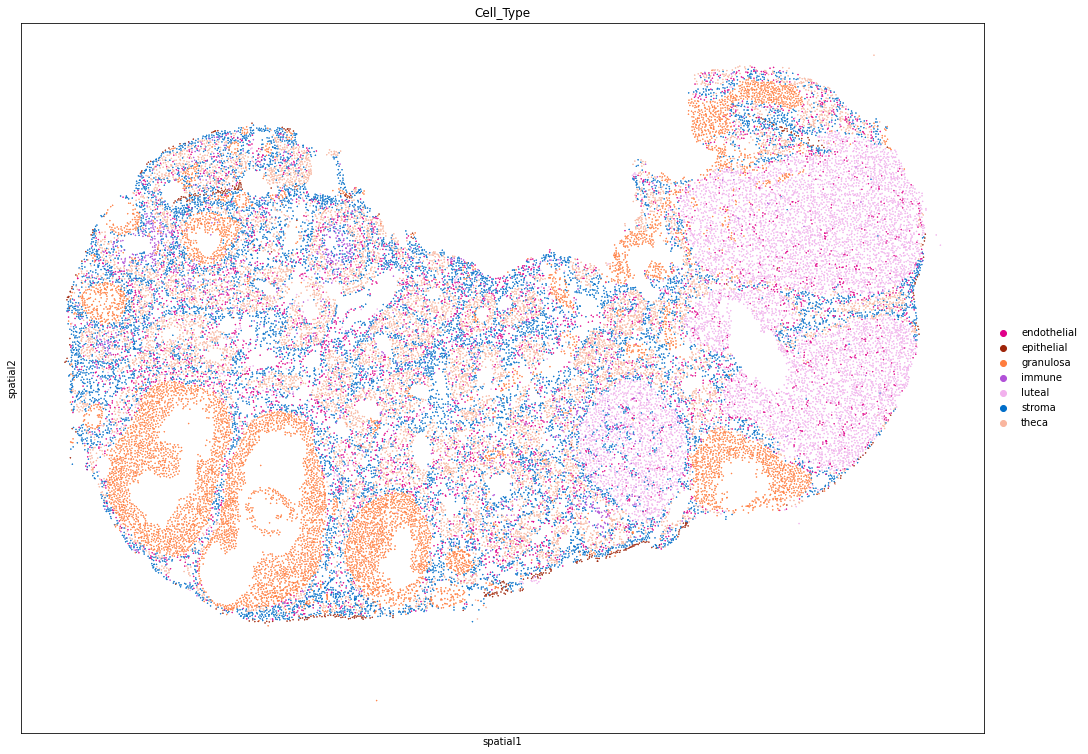

In [20]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="Cell_Type",
    size=0.5,
    library_id='spatial',
    figsize=(15, 15)
)


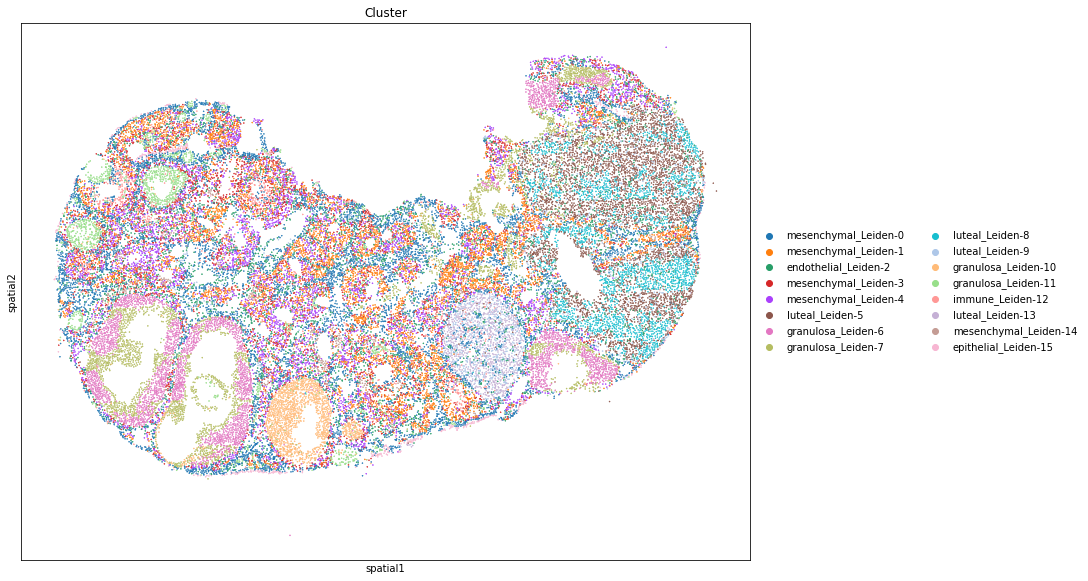

In [31]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="Cluster",
    size=0.5,
    library_id='spatial',
    figsize=(15, 15),
    cmap = 'tab20b',
)

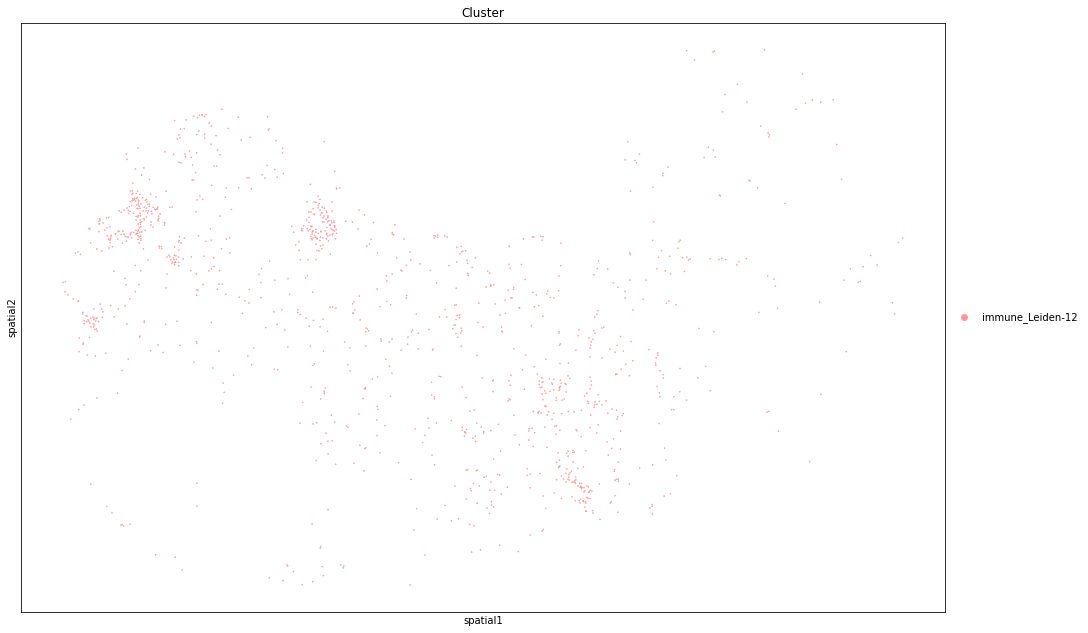

In [37]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="Cluster",
    groups = ['immune_Leiden-12'],
    size=0.5,
    library_id='spatial',
    figsize=(15, 15),
    cmap = 'tab20b',
)

  0%|          | 0/1000 [00:00<?, ?/s]

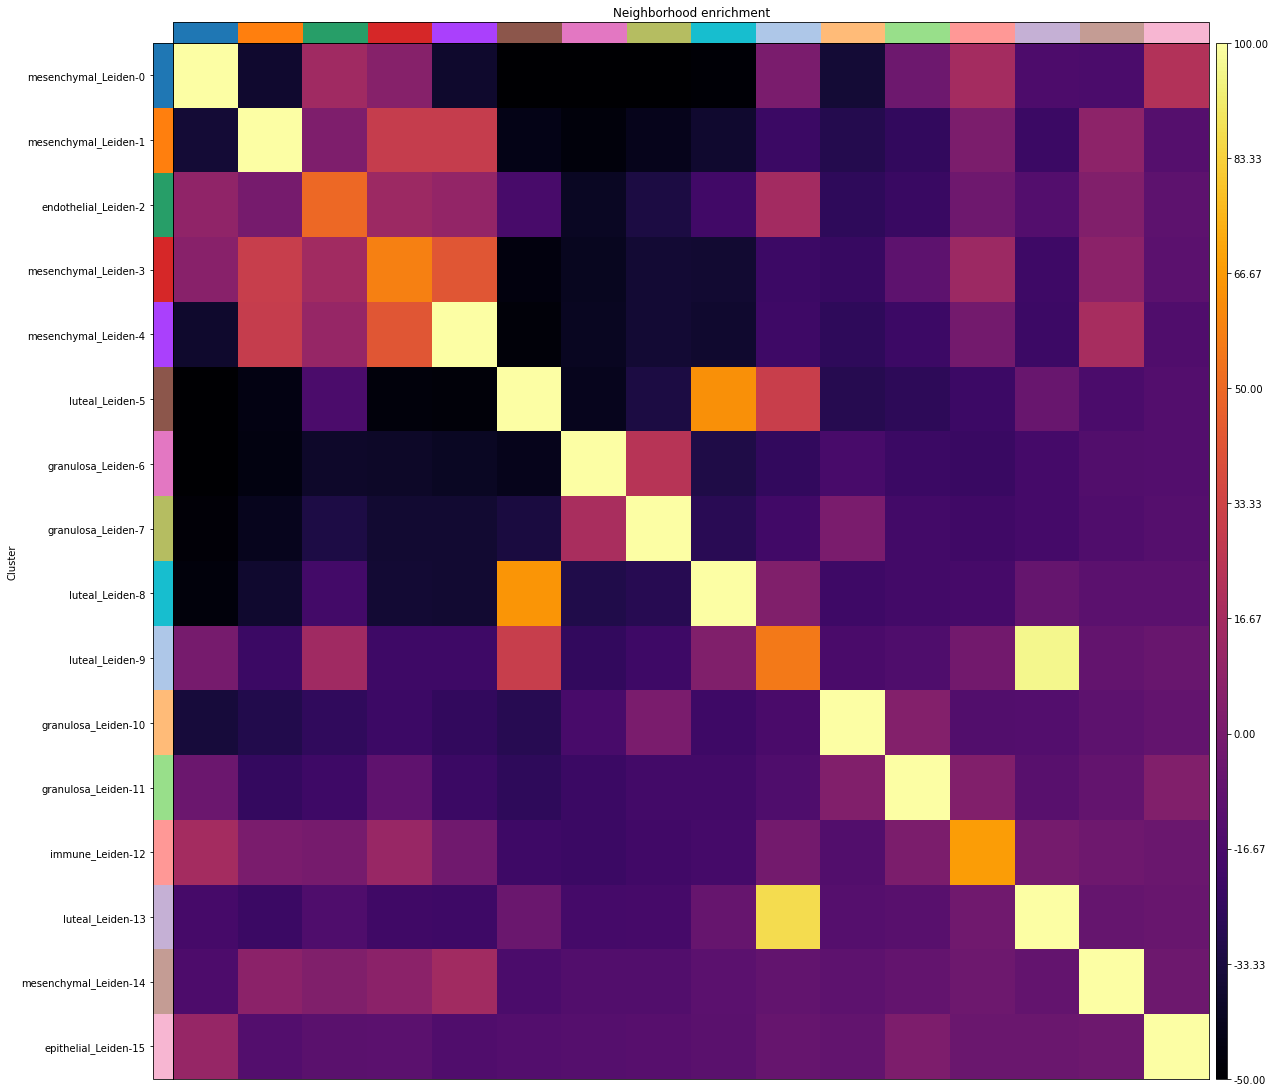

In [38]:
sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial")
sq.gr.nhood_enrichment(adata, cluster_key="Cluster")
sq.pl.nhood_enrichment(adata, cluster_key="Cluster", cmap="inferno", vmin=-50, vmax=100, figsize=(15,15))

In [39]:
sq.gr.spatial_autocorr(adata, mode="moran")
num_view = 12
top_autocorr = adata.uns['moranI']['I'].sort_values(ascending=False).head(num_view).index.tolist()
bot_autocorr = adata.uns['moranI']['I'].sort_values(ascending=True).head(num_view).index.tolist()

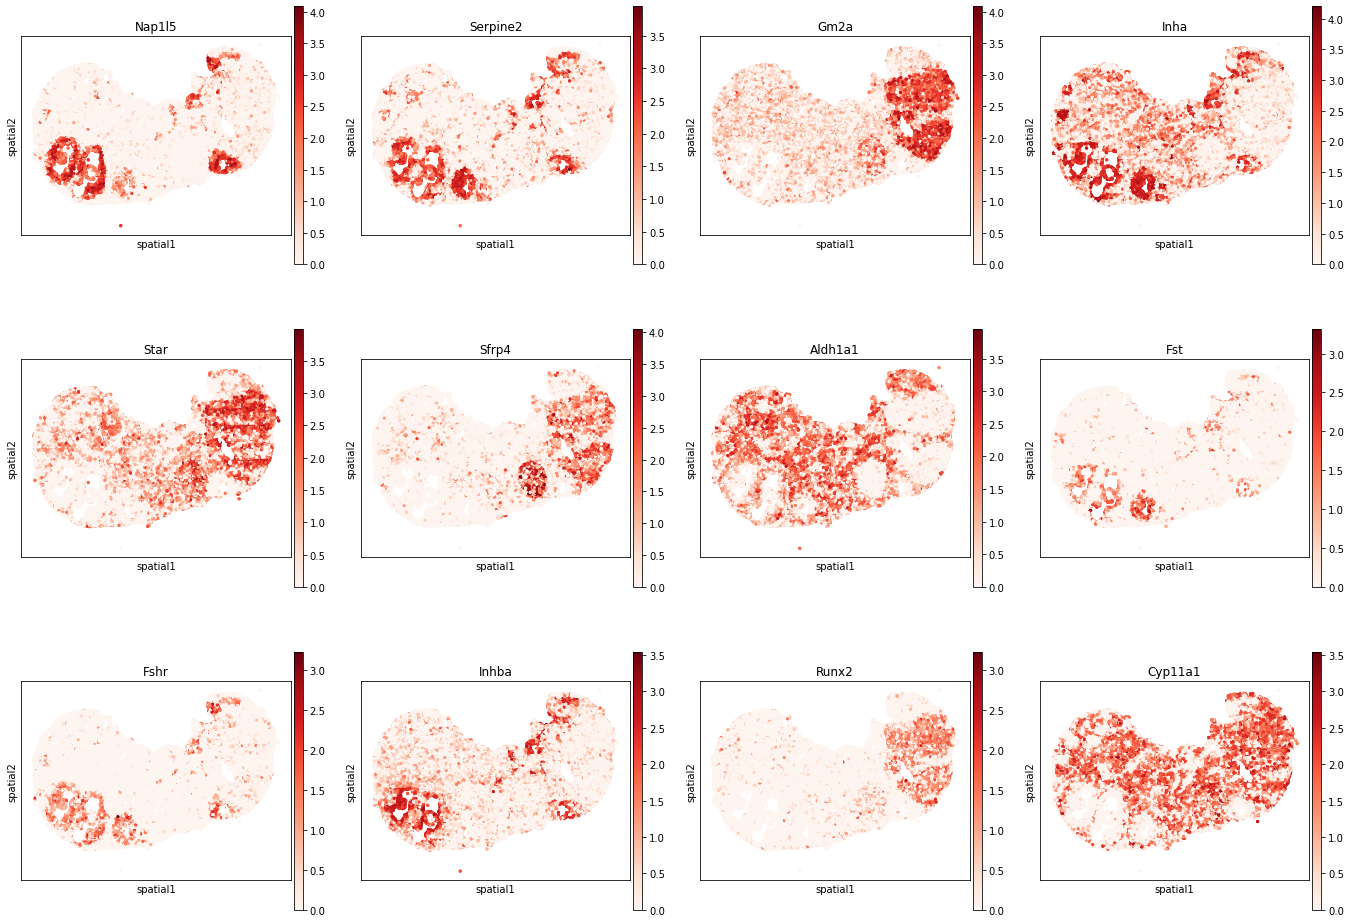

In [40]:
sq.pl.spatial_scatter(
    adata,
    color=top_autocorr,
    size=20,
    cmap='Reds',
    img=False,
    figsize=(5,5),
    shape = None,
    library_id='spatial',
)

In [41]:
sq.gr.centrality_scores(adata, cluster_key="Cluster")

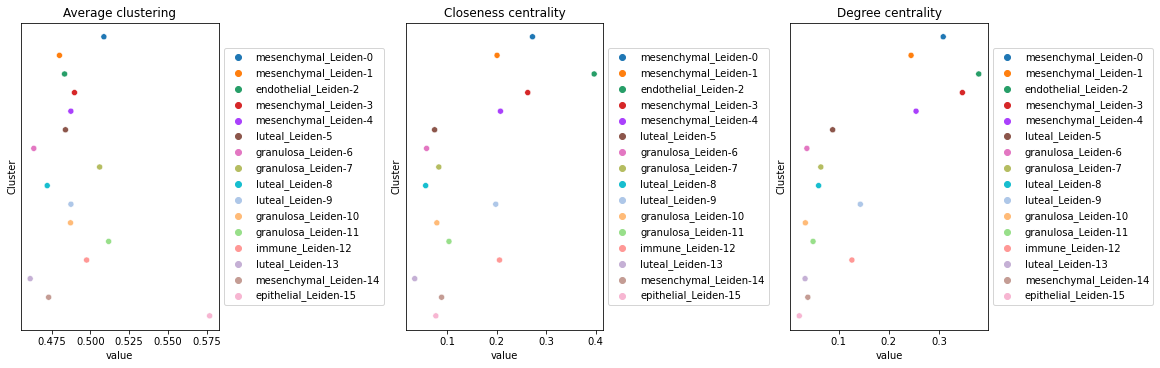

In [42]:
sq.pl.centrality_scores(adata, cluster_key="Cluster", figsize=(16, 5))

In [ ]:
genes_to_see=['Krt19',
'Timp1',
'Gdf9',
'Tnfsf11',
'Lhcgr',
'Drd4',
#'Vim',
'Gatm',
#'Snap25',
'Car2',
'Nos3',
'Sult1e1',
'Spp1',
'Tnfrsf1a',
'Cyp19a1',
'Fgl2',
'Amh',
'Prdm1',
'Slc41a2',
'Cd74',
'Has2',
'Foxl2',
'Wnt5a',
'Gas1',
'St3gal5',
'Lyz2',
'Ccr7',
'Foxo3',
'Taf7l',
'Kcne2',
'Furin',
'Sycp3',
'Cbfa2t3',
'Ror2',
'Pak3',
'Hspa1b',
'Ptprc',
'Pgr',
'Il7',
'Ncoa7',
'Enpp3',
'Dusp6',
'Amhr2']

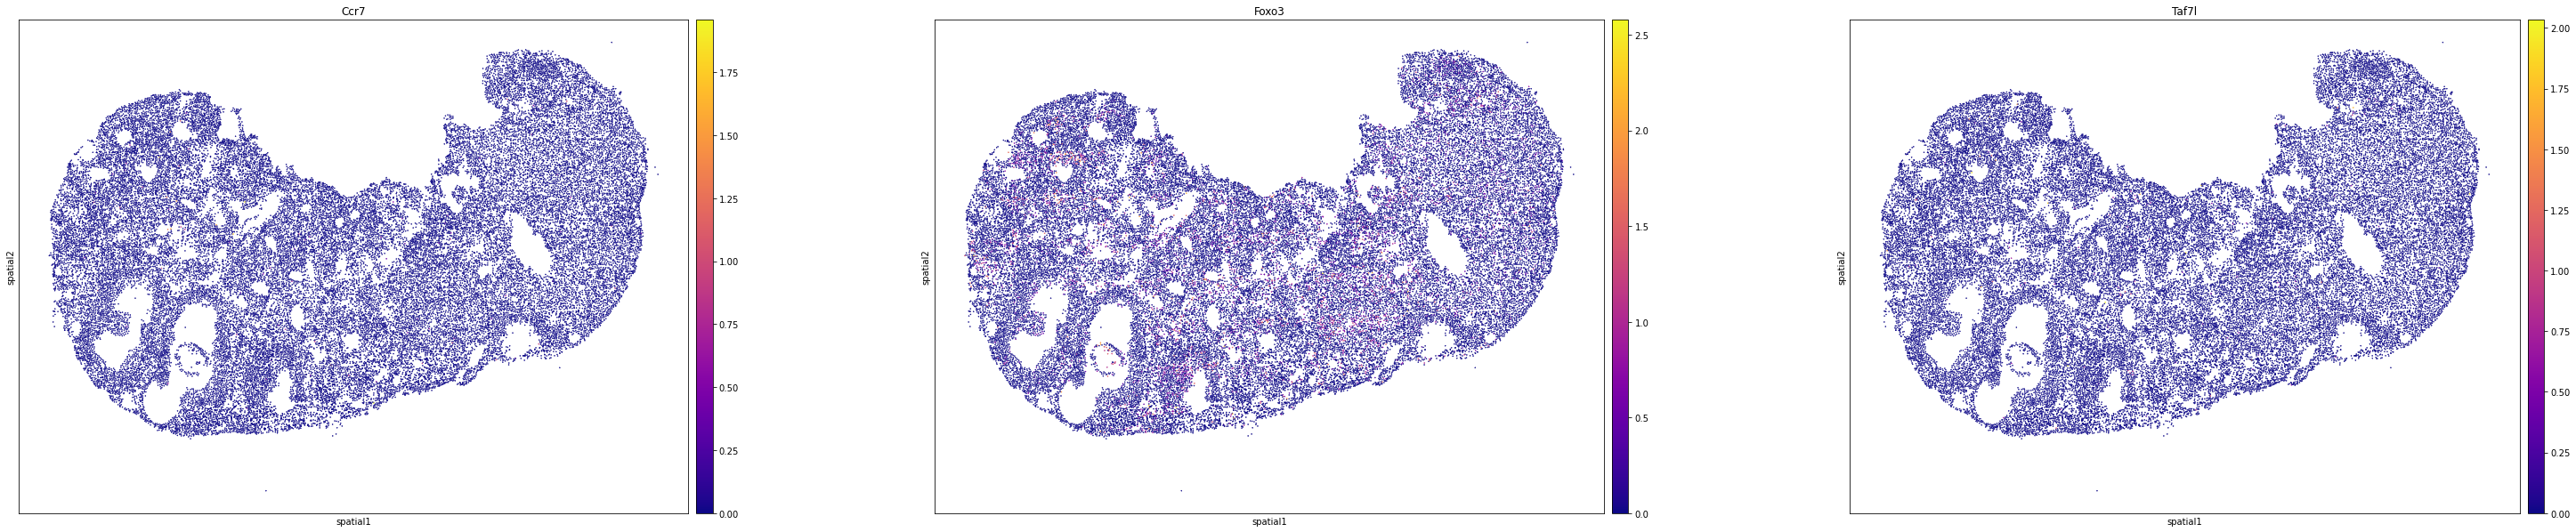

In [19]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=['Ccr7',
'Foxo3',
'Taf7l'],
    size=0.5,
    library_id='spatial',
    figsize=(15, 10),
    cmap = 'plasma',
)

In [25]:
adata.write('/home/jupyter/region_6/processed_region6.h5ad')